In [1]:
# uncomment local imports, comment google drive file import
# this version is not dependent on utils folder
# make changes by other

In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:
!pip install torchinfo optuna


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


# **Imports**

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

# import nndl.models.CNN as cnn
# import nndl.models.CNNLSTM as clstm
# import nndl.models.GRU as gru
# import nndl.utils as utils
import time
import gc

In [7]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using mps


# **Load data from localhost**

In [5]:
# X_test = np.load("./project_data/X_test.npy")
# y_test = np.load("./project_data/y_test.npy") - 769
# person_train_valid = np.load("./project_data/person_train_valid.npy")
# X_train_valid = np.load("./project_data/X_train_valid.npy")
# print(X_train_valid.shape)
# y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
# person_test = np.load("./project_data/person_test.npy")

# print(X_train_valid.shape)
# print(X_test.shape)

# print(y_train_valid)

# Load data from google drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
## Loading the dataset
X_test = np.load("/content/drive/MyDrive/project_data/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project_data/y_test.npy")-769
person_test = np.load("/content/drive/MyDrive/project_data/person_test.npy")
X_train_valid = np.load("/content/drive/MyDrive/project_data/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project_data/y_train_valid.npy")-769
person_train_valid = np.load("/content/drive/MyDrive/project_data/person_train_valid.npy")
print("---all data---")
print("X_test shape\t\t", X_test.shape)
print("y_test shape\t\t", y_test.shape)
print("person_test shape\t", person_test.shape)
print("X_train_valid shape\t", X_train_valid.shape)
print("y_train_valid shape\t", y_train_valid.shape)
print("person_train_valid shape", person_train_valid.shape)
print()

---all data---
X_test shape		 (443, 22, 1000)
y_test shape		 (443,)
person_test shape	 (443, 1)
X_train_valid shape	 (2115, 22, 1000)
y_train_valid shape	 (2115,)
person_train_valid shape (2115, 1)



# Load data for a subset of subjects

In [8]:
# # subjects is to load a subset of the data for a particular subject
# subjects = [0, 1, 2, 3, 4, 5, 6, 7, 8] #use 0-8 for subjects 1-9
# # subjects = [0] #use 0-8 for subjects 1-9

# X_test_subs = np.empty((0, X_test.shape[1], X_test.shape[2]))
# y_test_subs = np.empty((0))
# X_train_valid_subs = np.empty((0, X_train_valid.shape[1], X_train_valid.shape[2]))
# y_train_valid_subs = np.empty((0))

# for i in subjects:
#   sub = i
#   X_test_subs = np.concatenate( (X_test_subs, X_test[np.where(person_test == sub)[0],:,:] ))
#   y_test_subs = np.concatenate( (y_test_subs, y_test[np.where(person_test == sub)[0]] ))
#   X_train_valid_subs = np.concatenate(( X_train_valid_subs, X_train_valid[np.where(person_train_valid == sub)[0], :, :] ))
#   y_train_valid_subs = np.concatenate(( y_train_valid_subs, y_train_valid[np.where(person_train_valid == sub)[0]] ))

# X_test = X_test_subs
# y_test = y_test_subs
# X_train_valid = X_train_valid_subs
# y_train_valid = y_train_valid_subs
# print("---after isolating subjects---")
# print("X_test shape\t\t", X_test.shape)
# print("y_test shape\t\t", y_test.shape)
# print("X_train_valid shape\t", X_train_valid.shape)
# print("y_train_valid shape\t", y_train_valid.shape)

# train_model and test_model functions

In [9]:
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                train_loader=None,
                val_loader=None,
                test_loader=None,
                num_epochs=100,
                learning=False,
                device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'),
                trial=None):
    # we return these
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}')

        # ======================================================================
        # START OF TRAINING
        # ======================================================================
        model.train()
        train_count = 0
        train_correct_count = 0

        # minibatch
        for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
            train_x = train_x.float().to(device)
            train_y = train_y.long().to(device)

            logits = model(train_x)
            loss = criterion(logits, train_y)

            optimizer.zero_grad()   # no gradient accumulation between batches
            loss.backward()         # backprop
            optimizer.step()        # gradient step

            # training accuracy
            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == train_y, axis=-1)
                train_count += train_x.size(0)

        train_acc = train_correct_count / train_count
        train_accuracies.append(train_acc.item())
        # ======================================================================
        # END OF TRAINING
        # ======================================================================

        # ======================================================================
        # START OF VALIDATION
        # ======================================================================
        model.eval()
        val_count = 0
        val_correct_count = 0
        val_loss = 0

        # validation accuracy
        with torch.no_grad():
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float().to(device)
                val_y = val_y.long().to(device)

                logits = model(val_x).detach()
                y_hat = torch.argmax(logits, dim=-1)

                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_y.size(0)

                # for the learning rate scheduler
                val_loss = criterion(logits, val_y)

        val_acc = val_correct_count / val_count
        val_accuracies.append(val_acc.item())
        scheduler.step()
        # ======================================================================
        # END OF VALIDATION
        # ======================================================================

        # performance info
        print('Train acc: {:.3f}, Val acc: {:.3f}, Val loss: {:.3f}'.format(train_acc,
                                                                            val_acc,
                                                                            val_loss))

        if learning:
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================
            trial.report(val_acc.item(), epoch)
            # so my gpu doesn't shit itself, also gets rid of shit trials
            if trial.should_prune():
                # garbage collection so my gpu doesn't shit itself
                del model
                torch.cuda.empty_cache()
                gc.collect()
                raise optuna.TrialPruned()
            # ======================================================================
            # START OF TRIAL PRUNING
            # ======================================================================

    if learning:
        # garbage collection so my gpu doesn't shit itself
        del model
        torch.cuda.empty_cache()
        gc.collect()

    return train_accuracies, val_accuracies
# ==============================================================================
# END OF train_model()
# ==============================================================================


# ==============================================================================
# START OF test_model()
# ==============================================================================
def test_model(model,
               test_loader,
               device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')):
    model.eval()
    with torch.no_grad():
        test_count = 0
        test_correct_count = 0

        for _, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.float().to(device)
            test_y = test_y.long().to(device)

            logits = model(test_x).detach()
            y_hat = torch.argmax(logits, dim=-1)

            test_correct_count += torch.sum(y_hat == test_y, axis=-1)
            test_count += test_x.size(0)

        test_acc = test_correct_count / test_count
        print('Test acc: {:.3f}'.format(test_acc))
# ==============================================================================
# END OF test_model()
# ==============================================================================

# **Data Prep**

In [10]:
def data_prep(X,y,sub_sample,average,noise,p_channel_dropout,smooth_time_mask,mask_length):

    total_X = None
    total_y = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if p_channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= p_channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if smooth_time_mask:
        copy_X = copy.deepcopy(total_X)
        starts = ((torch.rand(copy_X.shape[0])*(copy_X.shape[3]-mask_length-1))).round()
        for idx, m in enumerate(copy_X):
            start = int(starts[idx])
            end = start+mask_length
            m[:,start:end] = 0
        total_X = torch.cat((total_X, copy_X))
        total_y = torch.cat((total_y, total_y))
        print(f'Shape of X after smooth time mask {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    return total_X,total_y

def test_data_prep(X):
    total_X = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, 2), axis=3)
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    return total_X


input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 1e-4
batch_size = 200
num_epochs = 100
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
p_channel_dropout = 0.2
smooth_time_mask = True
mask_size = 120
noise = True
'''
This was the old data prep.
The code below is just split up.
Split data, then split up X_train, X_val, X_test by subject and create dataloaders
Then dataprep and dataloader is performed for x_train etc
kept in case of error then can go back
i could have put them in lists
'''
'''
X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')
'''

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
#print(indices)
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
#print(split_idx)
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

person_train_valid, person_test = torch.Tensor(person_train_valid), torch.Tensor(person_test)
person_train, person_valid = person_train_valid[indices[:split_idx]], person_train_valid[indices[split_idx:]]

#check it matches
'''
index_zero = (indices == 0).nonzero(as_tuple=False) #index in indices that hold index 0 in X_train_valid and person_train_valid
print(index_zero)
print(indices[index_zero])
if index_zero > 1902: #in validation
  print(X_train_valid[0])
  print(X_train[index_zero - 1903])
  print(person_train[index_zero - 1903])
  print(person_train_valid[0])
else:
  print(X_train_valid[0])
  print(X_train[index_zero])
  print(person_train[index_zero])
  print(person_train_valid[0])
'''

################################################
#seperate X_train by subject using person_train
################################################

s_train = [[], [], [], [], [], [], [], [], []]
s_y_train = [[], [], [], [], [], [], [], [], []]
count_train = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_train, range(len(person_train))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_train[int(i[0])].append(X_train[j])
  s_y_train[int(i[0])].append(y_train[j])

  #for length check
  count_train[int(i[0])]+=1

print('subject counts: ', count_train)
print('subject count sum: ', sum(count_train))

#lebron
for (i, j, k) in zip(count_train, s_train, s_y_train):
  if i != len(j) or i != len(k):
    print("length issue")


print('\nsubject 0')
s0_train, s0_y_train = data_prep(torch.Tensor(np.asarray(s_train[0])), torch.Tensor(np.asarray(s_y_train[0])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 1')
s1_train, s1_y_train = data_prep(torch.Tensor(np.asarray(s_train[1])), torch.Tensor(np.asarray(s_y_train[1])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 2')
s2_train, s2_y_train = data_prep(torch.Tensor(np.asarray(s_train[2])), torch.Tensor(np.asarray(s_y_train[2])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 3')
s3_train, s3_y_train = data_prep(torch.Tensor(np.asarray(s_train[3])), torch.Tensor(np.asarray(s_y_train[3])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 4')
s4_train, s4_y_train = data_prep(torch.Tensor(np.asarray(s_train[4])), torch.Tensor(np.asarray(s_y_train[4])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 5')
s5_train, s5_y_train = data_prep(torch.Tensor(np.asarray(s_train[5])), torch.Tensor(np.asarray(s_y_train[5])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 6')
s6_train, s6_y_train = data_prep(torch.Tensor(np.asarray(s_train[6])), torch.Tensor(np.asarray(s_y_train[6])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 7')
s7_train, s7_y_train = data_prep(torch.Tensor(np.asarray(s_train[7])), torch.Tensor(np.asarray(s_y_train[7])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 8')
s8_train, s8_y_train = data_prep(torch.Tensor(np.asarray(s_train[8])), torch.Tensor(np.asarray(s_y_train[8])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)

#############################################
#seperate X_val by subject using person_valid
#############################################
print(X_valid.shape)

s_valid = [[], [], [], [], [], [], [], [], []]
s_y_valid = [[], [], [], [], [], [], [], [], []]
count_val = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_valid, range(len(person_valid))):
  #i is a np.darray from subject_train, i[0] gives us the subject
  #j is the index of i in subject_train that corresponds to the index in subject_train
  s_valid[int(i[0])].append(X_valid[j])
  s_y_valid[int(i[0])].append(y_valid[j])

  #for length check
  count_val[int(i[0])]+=1

print('val counts: ', count_val)
print('val count sum: ', sum(count_val))

#lebron
for (i, j, k) in zip(count_val, s_valid, s_y_valid):
  if i != len(j) or i != len(k):
    print("length issue")

print('\nsubject 0')
s0_valid, s0_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[0])), torch.Tensor(np.asarray(s_y_valid[0])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 1')
s1_valid, s1_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[1])), torch.Tensor(np.asarray(s_y_valid[1])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 2')
s2_valid, s2_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[2])), torch.Tensor(np.asarray(s_y_valid[2])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 3')
s3_valid, s3_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[3])), torch.Tensor(np.asarray(s_y_valid[3])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 4')
s4_valid, s4_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[4])), torch.Tensor(np.asarray(s_y_valid[4])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 5')
s5_valid, s5_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[5])), torch.Tensor(np.asarray(s_y_valid[5])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 6')
s6_valid, s6_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[6])), torch.Tensor(np.asarray(s_y_valid[6])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 7')
s7_valid, s7_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[7])), torch.Tensor(np.asarray(s_y_valid[7])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nsubject 8')
s8_valid, s8_y_valid = data_prep(torch.Tensor(np.asarray(s_valid[8])), torch.Tensor(np.asarray(s_y_valid[8])), subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)

#############################################
#seperate X_test by subject using person_test
#############################################
print(X_test.shape)

s_test = [[], [], [], [], [], [], [], [], []]
s_y_test = [[], [], [], [], [], [], [], [], []]
count_test = [0, 0, 0, 0, 0, 0, 0, 0, 0]

for (i, j) in zip(person_test, range(len(person_test))):
  #i is a np.darray from person_test, i[0] gives us the subject
  #j is the index of i in person_test that corresponds to the index in X_test
  s_test[int(i[0])].append(X_test[j])
  s_y_test[int(i[0])].append(y_test[j])

  #for length check
  count_test[int(i[0])]+=1

print('test counts: ', count_test)
print('test count sum: ', sum(count_test))

#lebron length check
for (i, j, k) in zip(count_test, s_test, s_y_test):
  if i != len(j) or i != len(k):
    print("length issue")

#Look in my eyes, tell me your tale Do you see the road, the map to my soul? Look, tell me the signs whenever the smoke clear out of my face Am I picture-perfect or do I look fried?
print('\nsubject 0')
s0_test, s0_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[0]))), torch.Tensor(np.asarray(s_y_test[0]))
print('\nsubject 1')
s1_test, s1_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[1]))), torch.Tensor(np.asarray(s_y_test[1]))
print('\nsubject 2')
s2_test, s2_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[2]))), torch.Tensor(np.asarray(s_y_test[2]))
print('\nsubject 3')
s3_test, s3_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[3]))), torch.Tensor(np.asarray(s_y_test[3]))
print('\nsubject 4')
s4_test, s4_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[4]))), torch.Tensor(np.asarray(s_y_test[4]))
print('\nsubject 5')
s5_test, s5_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[5]))), torch.Tensor(np.asarray(s_y_test[5]))
print('\nsubject 6')
s6_test, s6_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[6]))), torch.Tensor(np.asarray(s_y_test[6]))
print('\nsubject 7')
s7_test, s7_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[7]))), torch.Tensor(np.asarray(s_y_test[7]))
print('\nsubject 8')
s8_test, s8_y_test = test_data_prep(torch.Tensor(np.asarray(s_test[8]))), torch.Tensor(np.asarray(s_y_test[8]))

#############################
#Generate Subject DataLoader#
#############################

s0_train_loader = DataLoader(TensorDataset(s0_train, s0_y_train), batch_size=batch_size, shuffle=True)
s0_val_loader = DataLoader(TensorDataset(s0_valid, s0_y_valid), batch_size=batch_size, shuffle=True)
s0_test_loader = DataLoader(TensorDataset(s0_test, s0_y_test), batch_size=batch_size, shuffle=True)

s1_train_loader = DataLoader(TensorDataset(s1_train, s1_y_train), batch_size=batch_size, shuffle=True)
s1_val_loader = DataLoader(TensorDataset(s1_valid, s1_y_valid), batch_size=batch_size, shuffle=True)
s1_test_loader = DataLoader(TensorDataset(s1_test, s1_y_test), batch_size=batch_size, shuffle=True)

s2_train_loader = DataLoader(TensorDataset(s2_train, s2_y_train), batch_size=batch_size, shuffle=True)
s2_val_loader = DataLoader(TensorDataset(s2_valid, s2_y_valid), batch_size=batch_size, shuffle=True)
s2_test_loader = DataLoader(TensorDataset(s2_test, s2_y_test), batch_size=batch_size, shuffle=True)

s3_train_loader = DataLoader(TensorDataset(s3_train, s3_y_train), batch_size=batch_size, shuffle=True)
s3_val_loader = DataLoader(TensorDataset(s3_valid, s3_y_valid), batch_size=batch_size, shuffle=True)
s3_test_loader = DataLoader(TensorDataset(s3_test, s3_y_test), batch_size=batch_size, shuffle=True)

s4_train_loader = DataLoader(TensorDataset(s4_train, s4_y_train), batch_size=batch_size, shuffle=True)
s4_val_loader = DataLoader(TensorDataset(s4_valid, s4_y_valid), batch_size=batch_size, shuffle=True)
s4_test_loader = DataLoader(TensorDataset(s4_test, s4_y_test), batch_size=batch_size, shuffle=True)

s5_train_loader = DataLoader(TensorDataset(s5_train, s5_y_train), batch_size=batch_size, shuffle=True)
s5_val_loader = DataLoader(TensorDataset(s5_valid, s5_y_valid), batch_size=batch_size, shuffle=True)
s5_test_loader = DataLoader(TensorDataset(s5_test, s5_y_test), batch_size=batch_size, shuffle=True)

s6_train_loader = DataLoader(TensorDataset(s6_train, s6_y_train), batch_size=batch_size, shuffle=True)
s6_val_loader = DataLoader(TensorDataset(s6_valid, s6_y_valid), batch_size=batch_size, shuffle=True)
s6_test_loader = DataLoader(TensorDataset(s6_test, s6_y_test), batch_size=batch_size, shuffle=True)

s7_train_loader = DataLoader(TensorDataset(s7_train, s7_y_train), batch_size=batch_size, shuffle=True)
s7_val_loader = DataLoader(TensorDataset(s7_valid, s7_y_valid), batch_size=batch_size, shuffle=True)
s7_test_loader = DataLoader(TensorDataset(s7_test, s7_y_test), batch_size=batch_size, shuffle=True)

s8_train_loader = DataLoader(TensorDataset(s8_train, s8_y_train), batch_size=batch_size, shuffle=True)
s8_val_loader = DataLoader(TensorDataset(s8_valid, s8_y_valid), batch_size=batch_size, shuffle=True)
s8_test_loader = DataLoader(TensorDataset(s8_test, s8_y_test), batch_size=batch_size, shuffle=True)

subject_train_loader = [s0_train_loader, s1_train_loader, s2_train_loader, s3_train_loader, s4_train_loader, s5_train_loader, s6_train_loader, s7_train_loader,  s8_train_loader]
subject_val_loader = [s0_val_loader, s1_val_loader, s2_val_loader, s3_val_loader, s4_val_loader, s5_val_loader, s6_val_loader, s7_val_loader, s8_val_loader]
subject_test_loader = [s0_test_loader, s1_test_loader, s2_test_loader, s3_test_loader, s4_test_loader, s5_test_loader, s6_test_loader, s7_test_loader, s8_test_loader]


print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, p_channel_dropout, smooth_time_mask, mask_size)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
subject counts:  [218, 213, 213, 200, 209, 214, 212, 211, 213]
subject count sum:  1903

subject 0
Shape of X after trimming: torch.Size([218, 22, 800])
Shape of X after maxpooling: torch.Size([218, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([436, 22, 400])
torch.Size([436, 1])
torch.Size([218, 1])
torch.Size([654, 1])
torch.Size([218, 1])
Shape of X after subsampling and concatenating: torch.Size([872, 22, 400])
Shape of Y: torch.Size([872])
Shape of X after channel dropout torch.Size([1744, 22, 400])
Shape of Y: torch.Size([1744])
Shape of X after reverse torch.Size([2110, 22, 400])
Shape of Y: torch.Size([2110])

subject 1
Shape of X after trimming: torch.Size([213, 22, 800])
Shape of X after maxpooling: torch.Size([213, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([426, 22, 400])
torch.Size([426, 1])
torch.Size([213, 1])
torch.Size([639, 1])
torch.Size([213, 1])
Shape of X after subsampling 

In [11]:
# num_epochs = 50
# num_trials = 20
# start_time = time.time()

# **GRU**

In [12]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='GRU',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [13]:
# model = gru.GRU(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [14]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [15]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [16]:
# utils.test_model(model, test_loader)

In [17]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

# **CNN**

In [18]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='CNN',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [19]:
# model = cnn.CNN(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [20]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [21]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [22]:
# utils.test_model(model, test_loader)
# end_time = time.time()

In [23]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

# **CNNLSTM**

In [24]:
# class TimeDistributed(nn.Module):
#     def __init__(self, layer):
#         super(TimeDistributed, self).__init__()
#         self.layer = layer

#     def forward(self, x):
#         tmp = x.contiguous().view(-1, x.size(-1))
#         y = self.layer(tmp)
#         y = y.contiguous().view(x.size(0), -1, y.size(-1))

#         return y

In [25]:
# class CNNLSTM(nn.Module):
#     def __init__(self,
#                  num_classes=4,
#                  hidden_dims=256,
#                  num_layers=2,
#                  dropout=0.5,
#                  kernel=5,
#                  stride=2,
#                  padding=0,
#                  pool_kernel=2,
#                  time_bins=400,
#                  channels=22,
#                  depth=32):
#         super(CNNLSTM, self).__init__()

#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=channels,
#                       out_channels=depth,
#                       kernel_size=kernel,
#                       stride=stride,
#                       padding=padding),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.MaxPool1d(kernel_size=pool_kernel),
#             nn.Dropout(dropout)
#         )

#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth,
#                       kernel_size=kernel * 2,
#                       stride=stride,
#                       padding=padding + 1),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.Dropout(dropout)
#         )

#         self.conv3 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth,
#                       kernel_size=kernel * 4,
#                       stride=stride,
#                       padding=padding + 3),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth),
#             nn.Dropout(dropout)
#         )

#         self.conv4 = nn.Sequential(
#             nn.Conv1d(in_channels=depth,
#                       out_channels=depth * 4,
#                       kernel_size=kernel * 4,
#                       stride=stride,
#                       padding=padding + 5),
#             nn.ReLU(),
#             nn.BatchNorm1d(depth * 4),
#             nn.Dropout(dropout)
#         )

#         self.lstm1 = nn.LSTM(input_size=depth * 4,
#                              hidden_size=hidden_dims // 2,
#                              num_layers=num_layers,
#                              batch_first=True,
#                              bidirectional=True)

#         self.lstm2 = nn.LSTM(input_size=hidden_dims,
#                              hidden_size=hidden_dims // 2,
#                              num_layers=num_layers,
#                              batch_first=True,
#                              bidirectional=True)

#         self.td = nn.Sequential(
#             TimeDistributed(nn.Linear(in_features=hidden_dims,
#                                       out_features=hidden_dims // 2)),
#             TimeDistributed(nn.ELU()),
#             TimeDistributed(nn.BatchNorm1d(hidden_dims // 2)),
#             TimeDistributed(nn.Dropout(dropout)),

#             TimeDistributed(nn.Linear(in_features=hidden_dims // 2,
#                                       out_features=hidden_dims // 4)),
#             TimeDistributed(nn.ELU()),
#             TimeDistributed(nn.BatchNorm1d(hidden_dims // 4)),
#             TimeDistributed(nn.Dropout(dropout)),
#         )

#         self.dense = nn.Linear(in_features=hidden_dims // 4,
#                                out_features=num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = x.transpose(1, 2)
#         x, _ = self.lstm1(x)
#         x, _ = self.lstm2(x)
#         x = self.td(x)
#         x = x[:, -1, :]
#         x = self.dense(x)
#         return F.log_softmax(x, dim=1)




In [26]:
# torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

In [27]:
# params = utils.learn_hyperparameters(X_train=X_train,
#                                      y_train=y_train,
#                                      X_valid=X_valid,
#                                      y_valid=y_valid,
#                                      model_name='CNNLSTM',
#                                      num_epochs=num_epochs,
#                                      trials=num_trials)

In [28]:
# model = clstm.CNNLSTM(num_classes=4,
#               hidden_dims=params.get('hidden_dims'),
#               dropout=params.get('dropout'),
#               kernel=params.get('kernel'),
#               pool_kernel=params.get('pool_kernel'),
#               depth=params.get('depth'))

# criterion = nn.CrossEntropyLoss()
# if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'),
#                                                                     momentum=params.get('momentum'))
# else:
#     optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
#                                                                     lr=params.get('learning_rate'),
#                                                                     weight_decay=params.get('weight_decay'))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# torchinfo.summary(model, input_size=(params.get('batch_size'), 22, 400))

In [29]:
# model = CNNLSTM().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [30]:
# train_accuracies, val_accuracies = utils.train_model(model=model,
#                                                      criterion=criterion,
#                                                      optimizer=optimizer,
#                                                      scheduler=scheduler,
#                                                      train_loader=train_loader,
#                                                      val_loader=val_loader,
#                                                      num_epochs=num_epochs * 2,
#                                                      learning=False,
#                                                      device=device,
#                                                      trial=None)

In [31]:
# import matplotlib.pyplot as plt
# n_epochs = num_epochs * 2
# epochs = range(1, n_epochs + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

In [32]:
# utils.test_model(model, test_loader)
# end_time = time.time()

In [33]:
# del model
# torch.cuda.empty_cache()
# gc.collect()

In [34]:
# end_time = time.time()
# print('time i will never get back:')
# hours = (end_time - start_time) // 3600
# minutes = ((end_time - start_time) % 3600) // 60
# seconds = (end_time - start_time) % 60

# print(f'time to train models: \
# {hours} hours, \
# {minutes} minutes, \
# {int(seconds)} seconds')

# other

In [84]:
# update number of epochs
# change path to save
number_epochs = 1
path_to_save = '/content/drive/MyDrive/project_data/'
super_start_time = time.time()

In [134]:
def calc_time(end_time, start_time):
  hours = (end_time - super_start_time) // 3600
  minutes = ((end_time - super_start_time) % 3600) // 60
  seconds = (end_time - super_start_time) % 60

  print(f'time to train model: \
  {hours} hours, \
  {minutes} minutes, \
  {int(seconds)} seconds')

## cnn

In [85]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [86]:
class CNN(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=10,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
        )

        self.dense = nn.Linear(in_features=depth * 4,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        # print(x.shape)
        x = self.nd(x)
        x = x[:, -1, :]
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


In [87]:
batch_size = 256
torchinfo.summary(CNN(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [256, 4]                  --
├─Sequential: 1-1                        [256, 25, 391]            --
│    └─Conv1d: 2-1                       [256, 25, 391]            5,525
│    └─ReLU: 2-2                         [256, 25, 391]            --
│    └─BatchNorm1d: 2-3                  [256, 25, 391]            50
│    └─Dropout: 2-4                      [256, 25, 391]            --
├─Sequential: 1-2                        [256, 50, 1, 122]         --
│    └─Conv2d: 2-5                       [256, 50, 1, 367]         31,300
│    └─ReLU: 2-6                         [256, 50, 1, 367]         --
│    └─BatchNorm2d: 2-7                  [256, 50, 1, 367]         100
│    └─MaxPool2d: 2-8                    [256, 50, 1, 122]         --
│    └─Dropout: 2-9                      [256, 50, 1, 122]         --
├─Sequential: 1-3                        [256, 100, 37]            --
│    └─

In [88]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [89]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.325, Val acc: 0.261, Val loss: 1.437


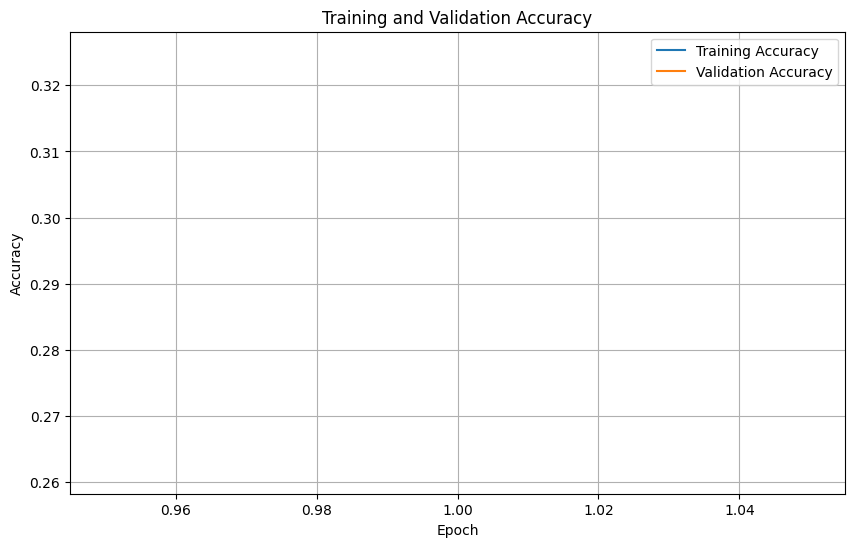

In [90]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [141]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

time to train models:   0.0 hours,   4.0 minutes,   49 seconds
Test acc: 0.242


In [92]:
torch.save(model, path_to_save+'cnn')

## shallow cnn

In [93]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [94]:
class Shallow(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 dropout=0.5,
                 kernel=25,
                 stride=1,
                 padding=0,
                 pool_kernel=50,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(Shallow, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 8,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 8),
            nn.AvgPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout),
            nn.Tanh()
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            nn.Linear(in_features=depth * 4, out_features=depth * 2),
            nn.ReLU(),
        )

        self.dense = nn.Linear(in_features=depth * 2,
                               out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x = self.dense(x)

        return F.log_softmax(x, dim=1)

In [95]:
batch_size = 128
torchinfo.summary(Shallow(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
Shallow                                  [128, 4]                  --
├─Sequential: 1-1                        [128, 25, 376]            --
│    └─Conv1d: 2-1                       [128, 25, 376]            13,775
│    └─ReLU: 2-2                         [128, 25, 376]            --
│    └─BatchNorm1d: 2-3                  [128, 25, 376]            50
│    └─Dropout: 2-4                      [128, 25, 376]            --
├─Sequential: 1-2                        [128, 200, 1, 7]          --
│    └─Conv2d: 2-5                       [128, 200, 1, 352]        125,200
│    └─ELU: 2-6                          [128, 200, 1, 352]        --
│    └─BatchNorm2d: 2-7                  [128, 200, 1, 352]        400
│    └─AvgPool2d: 2-8                    [128, 200, 1, 7]          --
│    └─Dropout: 2-9                      [128, 200, 1, 7]          --
│    └─Tanh: 2-10                        [128, 200, 1, 7]          --
├─Seq

In [96]:
model = Shallow().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.95)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [97]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.278, Val acc: 0.255, Val loss: 1.379


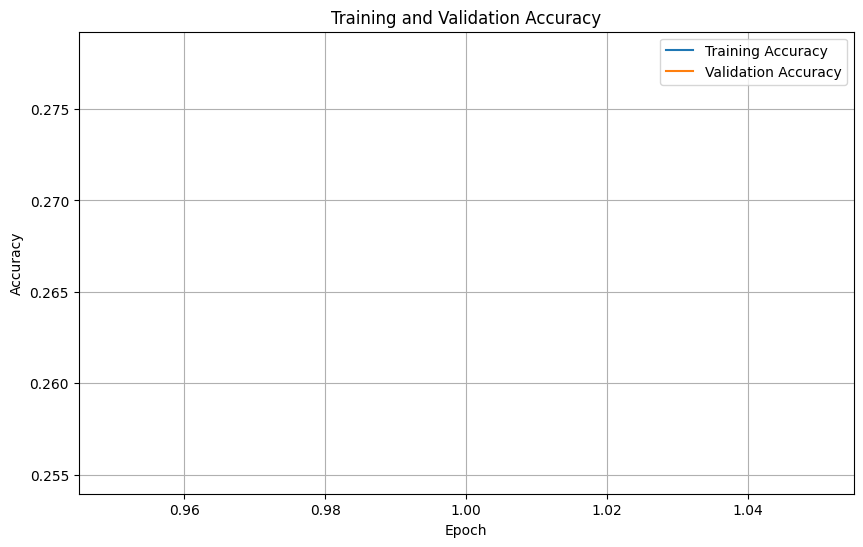

In [98]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

Test acc: 0.260


In [100]:
torch.save(model, path_to_save+'shallow_cnn')

## cnn lstm

In [101]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [102]:
class CNNLSTM(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=256,
                 num_layers=2,
                 dropout=0.5,
                 kernel=3,
                 stride=2,
                 padding=0,
                 pool_kernel=2,
                 time_bins=400,
                 channels=22,
                 depth=25):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.linear = nn.Sequential(
            nn.Linear(in_features=depth * 8,
                      out_features=depth * 8),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
        )

        self.lstm1 = nn.LSTM(input_size=depth * 4,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.lstm2 = nn.LSTM(input_size=depth * 8,
                             hidden_size=depth * 4,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            # TimeDistributed(nn.Dropout(dropout)),
            # TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            # TimeDistributed(nn.ReLU()),
            # TimeDistributed(nn.BatchNorm1d(depth * 2)),
            # TimeDistributed(nn.Dropout(dropout)),
        )

        self.dense = nn.Linear(in_features=depth * 4, out_features=num_classes)

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 4, out_features=depth * 2),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth * 2),
            # nn.Dropout(dropout),
            # nn.Linear(in_features=depth * 2, out_features=depth),
            # nn.ReLU(),
            # nn.BatchNorm1d(depth),
            # nn.Dropout(dropout),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.linear(x)
        x, _ = self.lstm1(x)
        #x, _ = self.lstm2(x)
        #x = self.td(x)
        x = self.nd(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [103]:
batch_size = 128
torchinfo.summary(CNNLSTM(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [128, 4]                  503,500
├─Sequential: 1-1                        [128, 25, 199]            --
│    └─Conv1d: 2-1                       [128, 25, 199]            1,675
│    └─ReLU: 2-2                         [128, 25, 199]            --
├─Sequential: 1-2                        [128, 50, 1, 44]          --
│    └─Conv2d: 2-3                       [128, 50, 1, 88]          31,300
│    └─ELU: 2-4                          [128, 50, 1, 88]          --
│    └─BatchNorm2d: 2-5                  [128, 50, 1, 88]          100
│    └─MaxPool2d: 2-6                    [128, 50, 1, 44]          --
│    └─Dropout: 2-7                      [128, 50, 1, 44]          --
├─Sequential: 1-3                        [128, 100, 24]            --
│    └─Conv1d: 2-8                       [128, 100, 24]            15,100
│    └─ELU: 2-9                          [128, 100, 24]            -

In [104]:
model = CNNLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [105]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.224, Val loss: 1.955


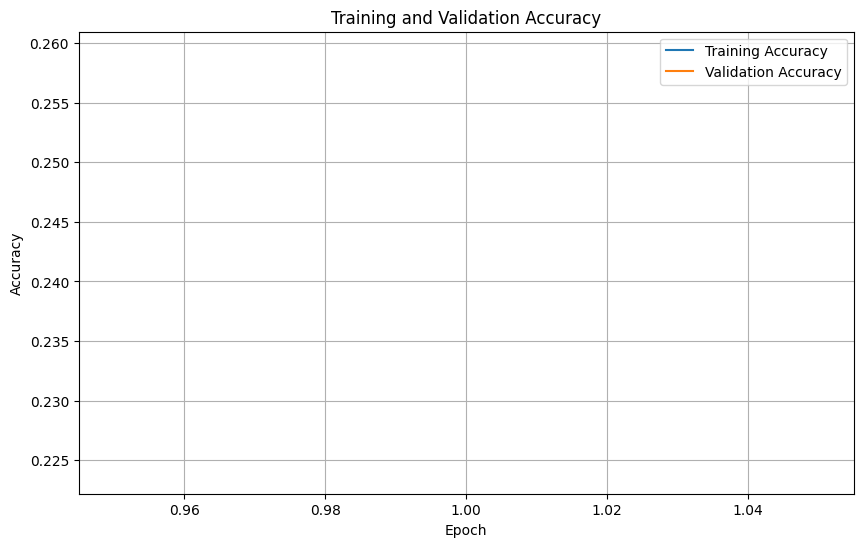

In [106]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

Test acc: 0.255


In [108]:
torch.save(model, path_to_save+'cnn_lstm')

## cnn gru

In [109]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        tmp = x.contiguous().view(-1, x.size(-1))
        y = self.layer(tmp)
        y = y.contiguous().view(x.size(0), -1, y.size(-1))

        return y

In [110]:
class GRU(nn.Module):
    def __init__(self,
                 num_classes=4,
                 hidden_dims=128,
                 num_layers=2,
                 dropout=0.5,
                 kernel=7,
                 stride=1,
                 padding=0,
                 pool_kernel=3,
                 time_bins=400,
                 channels=22,
                 depth=64):
        super(GRU, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=channels,
                      out_channels=depth,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding),
            nn.ReLU(),
            nn.BatchNorm1d(depth),
            nn.Dropout(dropout)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=depth,
                      out_channels=depth * 2,
                      kernel_size=(1, depth),
                      stride=stride,
                      padding=padding),
            nn.ELU(),
            nn.BatchNorm2d(depth * 2),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 2,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 1),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 4,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 3),
            nn.ELU(),
            nn.BatchNorm1d(depth * 4),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=depth * 4,
                      out_channels=depth * 8,
                      kernel_size=kernel,
                      stride=stride,
                      padding=padding + 5),
            nn.ELU(),
            nn.BatchNorm1d(depth * 8),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.nd = nn.Sequential(
            nn.Linear(in_features=depth * 8, out_features=depth * 4),
            nn.ReLU(),
            nn.BatchNorm1d(depth * 4),
            nn.Dropout(dropout),
        )

        self.gru = nn.GRU(input_size=depth * 4,
                           hidden_size=depth * 4,
                           num_layers=num_layers,
                           bias=True,
                           batch_first=True,
                           bidirectional=True)

        self.td = nn.Sequential(
            TimeDistributed(nn.Linear(in_features=depth * 8, out_features=depth * 4)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 4)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 4, out_features=depth * 2)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth * 2)),
            TimeDistributed(nn.Dropout(dropout)),
            TimeDistributed(nn.Linear(in_features=depth * 2, out_features=depth)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.BatchNorm1d(depth)),
            TimeDistributed(nn.Dropout(dropout)),
        )
        self.dense = nn.Linear(in_features=depth * 8, out_features=num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)
        x = self.conv2(x)
        x = x.squeeze(2)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.transpose(1, 2)
        x = x[:, -1, :]
        x = self.nd(x)
        x, _ = self.gru(x)
        #x = self.td(x)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [111]:
batch_size = 64
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [64, 4]                   173,376
├─Sequential: 1-1                        [64, 64, 394]             --
│    └─Conv1d: 2-1                       [64, 64, 394]             9,920
│    └─ReLU: 2-2                         [64, 64, 394]             --
│    └─BatchNorm1d: 2-3                  [64, 64, 394]             128
│    └─Dropout: 2-4                      [64, 64, 394]             --
├─Sequential: 1-2                        [64, 128, 1, 110]         --
│    └─Conv2d: 2-5                       [64, 128, 1, 331]         524,416
│    └─ELU: 2-6                          [64, 128, 1, 331]         --
│    └─BatchNorm2d: 2-7                  [64, 128, 1, 331]         256
│    └─MaxPool2d: 2-8                    [64, 128, 1, 110]         --
│    └─Dropout: 2-9                      [64, 128, 1, 110]         --
├─Sequential: 1-3                        [64, 256, 35]             --


In [112]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [113]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.269, Val acc: 0.230, Val loss: 1.449


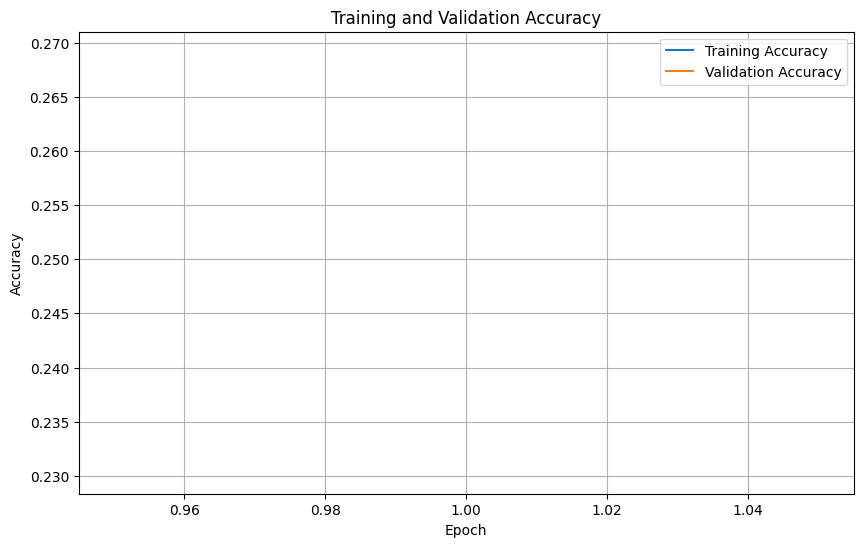

In [114]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [115]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

Test acc: 0.271


(None, 7.204078674316406)

In [116]:
torch.save(model, path_to_save+'cnn_gru')

## lstm-lstm

In [117]:
class LSTM_LSTM(nn.Module):
    def __init__(self,
                 input_size = 22,
                 hidden_size = 64,
                 num_layers = 2,
                 output_size = 54,
                 num_classes = 4):
        super(LSTM_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)

        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size * 2,
                             hidden_size,
                             num_layers,
                             batch_first=True,
                             bidirectional=True)


        # Output layer
        self.linear = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size-10),
            nn.BatchNorm1d(num_features=output_size-10, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(output_size-10, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Forward pass through LSTM1
        out, _ = self.lstm1(x)

        # Forward pass through LSTM2
        out, _ = self.lstm2(out)

        # fc layer
        out = self.linear(out[:, -1, :])
        return out


In [118]:
batch_size = 64
torchinfo.summary(LSTM_LSTM(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_LSTM                                [64, 54]                  2,688
├─LSTM: 1-1                              [64, 400, 128]            144,384
├─LSTM: 1-2                              [64, 400, 128]            198,656
├─Linear: 1-3                            [64, 54]                  6,966
Total params: 352,694
Trainable params: 352,694
Non-trainable params: 0
Total mult-adds (G): 8.78
Input size (MB): 2.25
Forward/backward pass size (MB): 52.46
Params size (MB): 1.40
Estimated Total Size (MB): 56.11

In [119]:
model = LSTM_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [120]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.245, Val acc: 0.224, Val loss: 1.446


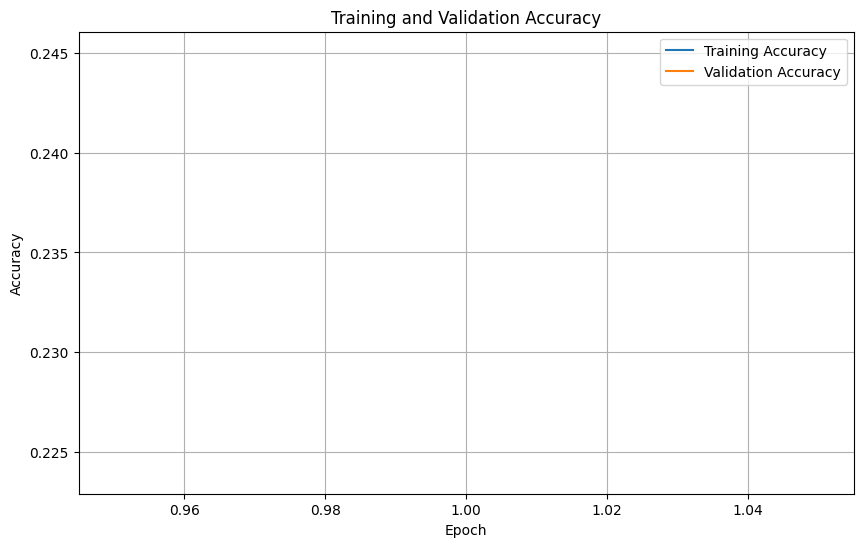

In [121]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

Test acc: 0.242


1710401991.808197

In [123]:
torch.save(model, path_to_save+'lstm_lstm')

## gru

In [124]:
class GRU(nn.Module):
    def __init__(self,
                 input_size = 22,
                 hidden_size = 64,
                 num_layers = 3,
                 output_size = 54,
                 num_classes = 4):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU Layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, bidirectional=True)

        # Output layer
        self.linear = nn.Linear(hidden_size * 2, output_size)
        self.fc = nn.Sequential(
            nn.Linear(output_size, output_size-10),
            nn.BatchNorm1d(num_features=output_size-10, eps=1e-05, momentum=0.2, affine=True),
            nn.ReLU(inplace = True),
            nn.Linear(output_size-10, num_classes)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Forward pass through GRU
        out, _ = self.gru(x)

        # fc layer
        out = self.linear(out[:, -1, :])
        return out


In [125]:
batch_size = 64
torchinfo.summary(GRU(), input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [64, 54]                  2,688
├─GRU: 1-1                               [64, 400, 128]            182,784
├─Linear: 1-2                            [64, 54]                  6,966
Total params: 192,438
Trainable params: 192,438
Non-trainable params: 0
Total mult-adds (G): 4.68
Input size (MB): 2.25
Forward/backward pass size (MB): 26.24
Params size (MB): 0.76
Estimated Total Size (MB): 29.25

In [126]:
model = GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0008)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)

In [127]:
start_time = time.time()
train_accuracies, val_accuracies = train_model(model=model,
                                                     criterion=criterion,
                                                     optimizer=optimizer,
                                                     scheduler=scheduler,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     num_epochs=number_epochs,
                                                     learning=False,
                                                     device=device,
                                                     trial=None)

Epoch 1


  0%|          | 0/92 [00:00<?, ?it/s]

Train acc: 0.245, Val acc: 0.207, Val loss: 1.396


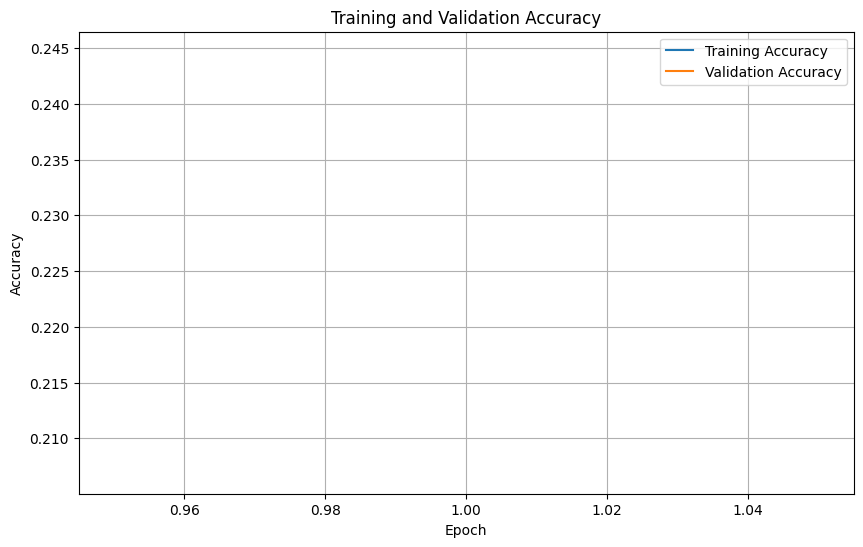

In [128]:
import matplotlib.pyplot as plt
n_epochs = number_epochs
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [129]:
end_time = time.time()
calc_time(end_time, start_time)
test_model(model, test_loader)

Test acc: 0.242


(None, 4.975580215454102)

In [130]:
torch.save(model, path_to_save+'gru')

# end

In [143]:
print('time i will never get back:')
hours = (end_time - super_start_time) // 3600
minutes = ((end_time - super_start_time) % 3600) // 60
seconds = (end_time - super_start_time) % 60

print(f'time to train models: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

time i will never get back:
time to train models: 0.0 hours, 4.0 minutes, 49 seconds
